In [13]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import numpy as np
import matplotlib
import tkinter
import matplotlib.pyplot as plt
import random
# matplotlib.use('TkAgg')
# %matplotlib widget
%matplotlib inline 
from PIL import Image
import IPython

import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
from stretch_body.robot import Robot
from scipy.spatial.transform import Rotation
from re1_utils.camera import get_cur_rs_frame
from re1_utils.controls import reset_head_position
from POI.point_of_interest import POI


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Object Detection**: From yolov7

In [2]:
import sys
#Gotta stay in the yolov7 directory
sys.path.append('./yolov7/')
from yolov7.predict import load_model, load_config

In [3]:
#Load config from yaml
CONFIG_PATH = './yolov7/predict_config.yaml'
config_dict = load_config(CONFIG_PATH)

#Load model, edit yolov7.pt path, get model/stride/device from model config
model, stride, device = load_model(config_dict, '../yolov7/yolov7.pt')


[INFO] [utils.torch_utils]: YOLOR 🚀 a0bbdb1 torch 1.12.1+cu102 CPU



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


[INFO] [utils.torch_utils]: Model Summary: 306 layers, 36905341 parameters, 36905341 gradients


Read sample img

In [4]:
#Reset the camera tilt and pan to 0 degrees
reset_head_position()

Frames Captured


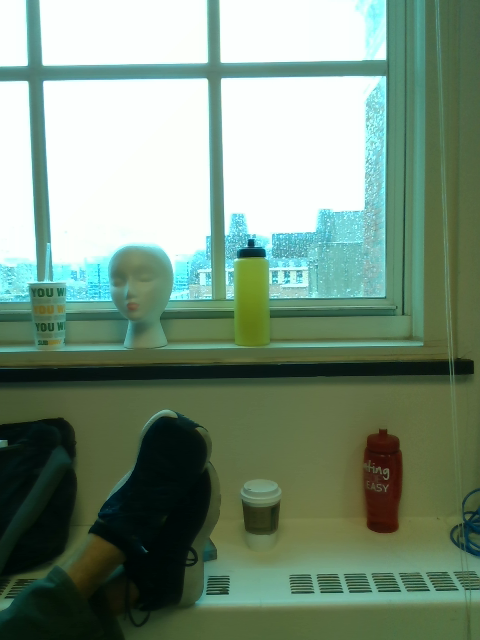

In [18]:
color_frame, color, depth_frame, depth = get_cur_rs_frame()
IPython.display.display(Image.fromarray(color))


[[        233         238         271         347      0.8881          39]
 [         26         281          67         349     0.85672          41]
 [        363         428         403         534      0.8054          39]
 [        240         478         282         552     0.74662          41]
 [          1         410         221         638     0.49501           0]
 [        107         243         174         349     0.37016          75]
 [          0         421          78         578     0.34161          26]]


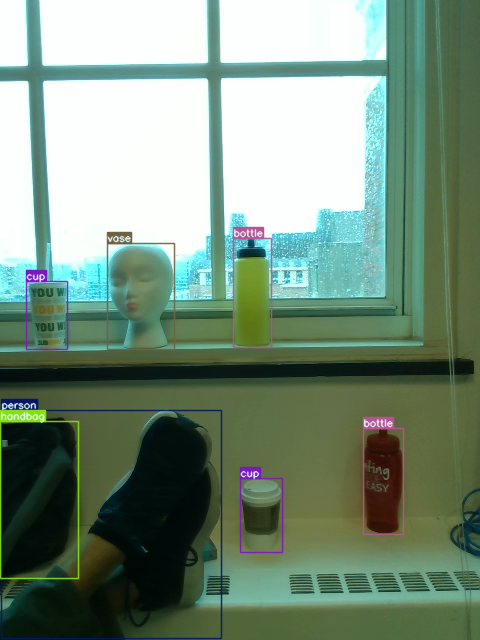

In [19]:
from re1_utils.objdet_utils import plot_all_boxes, predict

pred = predict(model, config_dict, color, stride, device)
print(pred)
#xyxy, conf_score, class
color = np.ascontiguousarray(color, dtype=np.uint8)
plot_all_boxes(pred, color)
IPython.display.display(Image.fromarray(color))


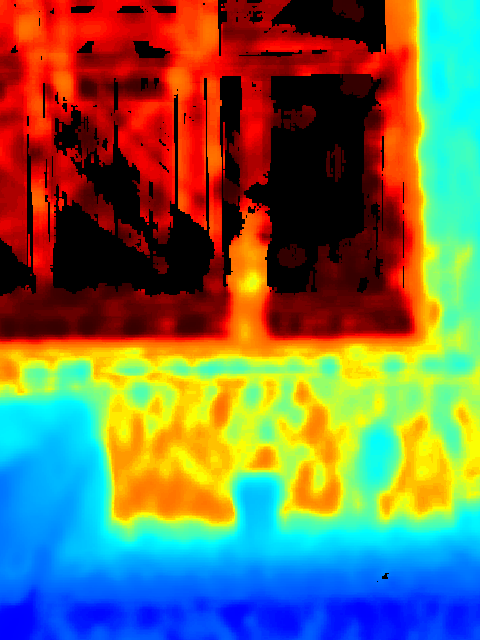

In [7]:
from re1_utils.camera import get_rs_colorized_depth
colorized_depth = get_rs_colorized_depth(depth_frame=depth_frame)

IPython.display.display(Image.fromarray(colorized_depth))


In [8]:
from re1_utils.controls import move_head 
from math import radians
from re1_utils.camera import get_cur_rs_frame
from POI.landmark_screen import LandmarkScreen
from re1_utils.camera import get_rs_intrinsic_mat
from re1_utils.camera import get_rs_extrinsic_mat


def pre_grasping_perception_singleObj(sample_size = 5):
    reset_head_position()
    #Return sampled measurement of the FIRST object 
    world_coords = np.zeros(3)
    
    #Sampling the measurements multiple times, at the same camera angle 0 degrees
    for i in range(sample_size): #range(-15,15,5):
        # Tilt camera to for multiple measurement from different angles. As we discussed, this unecessarily produces errors with coordinate mapping and depth
        # move_head('head_tilt',radians(i) )

        #Get frame
        color_frame, color, depth_frame, depth = get_cur_rs_frame()
        
        #Visualize
        # color = np.ascontiguousarray(color, dtype=np.uint8)
        pred = predict(model, config_dict, color, stride, device)
        # plot_all_boxes(pred, color)
        # IPython.display.display(Image.fromarray(color))
        
        #Landmark screen is object created to contain "landmarks" and "objects"
        landmark_screen = LandmarkScreen(color_frame=color, depth_frame=depth)
        landmark_screen.update_OOI(pred) #Update object detections
        
        #Get intrinsic and extrinsic matrices
        intrinsic_mat = get_rs_intrinsic_mat() 
        inv_intrinsic_mat = np.linalg.inv(intrinsic_mat)
        extrinsic_mat = get_rs_extrinsic_mat(type = 'cam2world')
        
        #Does what is said
        landmark_screen.update_cam_coords(inv_intrinsic_mat)
        landmark_screen.update_base_coords(extrinsic_mat)
        
        #landmark_screen.get_OOI() output the "sorted" list of object POI (points of interests). POI contains img_coord, cam_coord, base_coord
        bottle = landmark_screen.get_OOI()[0]
        print(bottle.img_coord, bottle.cam_coord, bottle.base_coord)
        world_coords += np.array(bottle.base_coord)
    
    return world_coords/sample_size

In [10]:
pre_grasping_perception_singleObj()

Frames Captured
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[251 289   1] [     1.2719   -0.033956    0.056679] [     1.2723   -0.033956      1.3334]
Frames Captured
[251 289   1] [     1.2768   -0.034086    0.056897] [     1.2772   -0.034086      1.3336]
Frames Captured
[251 290   1] [     1.2598   -0.033633    0.054063] [     1.2602   -0.033633      1.3309]
Frames Captured
[251 289   1] [     1.2796   -0.034162    0.057023] [       1.28   -0.034162      1.3337]
Frames Captured
[251 290   1] [      1.267   -0.033824     0.05437] [     1.2673   -0.033824      1.3311]


array([     1.2714,   -0.033932,      1.3325])

In [11]:
#Ignore this
def pre_grasping_perception_multipleObjs(sample_size = 5):
    #Return sampled measurement of the FIRST object 
    world_coords = np.zeros(3)
    final_list_of_Objs = []
    dict_of_Objs_sampled = {}
    
    #Sampling the measurements multiple times, at the same camera angle 0 degrees
    for i in range(sample_size):

        #Get frame
        color_frame, color, depth_frame, depth = get_cur_rs_frame()
        
        #Visualize
        # color = np.ascontiguousarray(color, dtype=np.uint8)
        pred = predict(model, config_dict, color, stride, device)
        # plot_all_boxes(pred, color)
        # IPython.display.display(Image.fromarray(color))
        
        #Landmark screen is object created to contain "landmarks" and "objects"
        landmark_screen = LandmarkScreen(color_frame=color, depth_frame=depth)
        landmark_screen.update_OOI(pred) #Update object detections
        
        #Get intrinsic and extrinsic matrices
        intrinsic_mat = get_rs_intrinsic_mat() 
        inv_intrinsic_mat = np.linalg.inv(intrinsic_mat)
        extrinsic_mat = get_rs_extrinsic_mat(type = 'cam2world')
        
        #Does what is said
        landmark_screen.update_cam_coords(inv_intrinsic_mat)
        landmark_screen.update_base_coords(extrinsic_mat)
        
        #landmark_screen.get_OOI() output the "sorted" list of object POI (points of interests). POI contains img_coord, cam_coord, base_coord
        dict_of_Objs_sampled[i] = landmark_screen.get_OOI()
        
        
    for key in dict_of_Objs_sampled.keys():
        #Assuming the number of objects do not change, and the order of the objects does not change
        if key == 0:
            for element in dict_of_Objs_sampled[0]:
                final_list_of_Objs.append(POI(img_coord = [0,0], depth = 0)) #TODO: Edit this to OOI
                
        raise len(dict_of_Objs_sampled[key]) == len(final_list_of_Objs)
        for i in range(len(dict_of_Objs_sampled[key])):
            final_list_of_Objs[i].img_coord += dict_of_Objs_sampled[key][i]
            final_list_of_Objs[i].cam_coord += dict_of_Objs_sampled[key][i]
            final_list_of_Objs[i].base_coord += dict_of_Objs_sampled[key][i]
        
    for i in range(len(final_list_of_Objs)):
        final_list_of_Objs[i].img_coord /= sample_size
        final_list_of_Objs[i].cam_coord /= sample_size
        final_list_of_Objs[i].base_coord /= sample_size
    return final_list_of_Objs

In [21]:
3/2

1.5